In [6]:
pip install ema_workbench

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install SALib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install requests

In [7]:
# importing the virus on a network file from GitHub (for Google colab)
import requests
url = 'https://raw.githubusercontent.com/BROSE-Uninc/SSF2021/main/virus_on_network/model.py?token=ADZHPYT3LJGR6RIP6L4XGW3AGQMMA'
r = requests.get(url)

with open('model.py', 'w') as f:
  f.write(r.text)
import model

### EMA imports

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from ema_workbench import (ReplicatorModel, RealParameter, BooleanParameter, IntegerParameter, 
Constant, TimeSeriesOutcome, perform_experiments, save_results, ema_logging)

ema_logging.log_to_stderr(ema_logging.INFO)

/Users/kleinraphael/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
/Users/kleinraphael/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

### Define Mesa model

In this part, we define the virus on network as a function. This function will be used by the EMA workbench later on.

In [9]:
# setting up the virus on network model simulation as a function
def model_virus_on_network(num_nodes=1, 
                            avg_node_degree=1, 
                            initial_outbreak_size=1, 
                            virus_spread_chance=1, 
                            virus_check_frequency=1, 
                            recovery_chance=1, 
                            gain_resistance_chance=1,
                            steps=10):
    
    # importing the virus on network example from mesa (copied in the repository)
#     from virus_on_network import model # for jupyter
    import model # for colab
    
    #initialising the model
    virus_on_network = model.VirusOnNetwork(num_nodes=num_nodes, 
                                avg_node_degree=avg_node_degree, 
                                initial_outbreak_size=initial_outbreak_size, 
                                virus_spread_chance=virus_spread_chance, 
                                virus_check_frequency=virus_check_frequency, 
                                recovery_chance=recovery_chance, 
                                gain_resistance_chance=gain_resistance_chance)
    
    # running mode for a number of steps
    virus_on_network.run_model(steps)
    # collecting and saving the final states of the model
    outcomes = virus_on_network.datacollector.get_model_vars_dataframe()
    
    # returning all of the states of the model
    return {'TIME':list(range(steps + 1)),
            "Infected": outcomes["Infected"].tolist(),
            "Susceptible": outcomes["Susceptible"].tolist(),
            "Resistant": outcomes["Resistant"].tolist()}
    

### Test Mesa model

This part illustrates how the virus on network mesa model is run using Python.

In [10]:
# running the model for 10 steps, with 20 nodes, ...
model_virus_on_network(num_nodes=20, 
                            avg_node_degree=3, 
                            initial_outbreak_size=1, 
                            virus_spread_chance=0.4, 
                            virus_check_frequency=0.2, 
                            recovery_chance=0.4, 
                            gain_resistance_chance=0.3,
                            steps=10)

{'TIME': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Infected': [1, 1, 1, 3, 2, 3, 7, 12, 18, 17, 18],
 'Susceptible': [19, 19, 19, 17, 18, 17, 13, 8, 2, 3, 2],
 'Resistant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

### Design EMA experiments

In this part, we define the experiments. First, we initialise the workbench, then we define the parameters that need to change from experiment to experiment, we define the constant parameters (number of steps and initial outbreak) and finally we define the output parameters.

In [4]:
# loading the model into the EMA workbench
model = ReplicatorModel('virusnetwork', function=model_virus_on_network)

In [5]:
# defining ranges for the parameters to be varied
model.uncertainties = [IntegerParameter("num_nodes", 10, 100),
                       IntegerParameter("avg_node_degree", 2, 8),
                        RealParameter("virus_spread_chance", 0.1, 1),
                        RealParameter("virus_check_frequency", 0.1, 1),
                        RealParameter("recovery_chance", 0.1, 1),
                        RealParameter("gain_resistance_chance", 0.1, 1)]

In [6]:
# defining the parameters that will remain constant
model.constants = [Constant("initial_outbreak_size", 1),
                  Constant('steps', 30)]

In [7]:
# defining the outputs of interests from the model
model.outcomes = [TimeSeriesOutcome('TIME'),
                TimeSeriesOutcome('Infected'),
                 TimeSeriesOutcome('Susceptible'),
                 TimeSeriesOutcome('Resistant')]

In [8]:
# defining the number of replications
model.replications = 10

### Perform EMA experiments

In this part we run the EMA experiments using the previously set parameters. We then store the results.

In [9]:
# running the EMA experiments with the aforementioned parameters and outputs
results = perform_experiments(model, 100)

# opening the results
experiments, outcomes = results

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


### Process outcomes

In [10]:
import random

In [11]:
outcomes[random.choice(list(outcomes))].shape

(100, 10, 31)

In [12]:
#get shape of every outcome (should all be identical?)
# for k in list(outcomes):
#     print(outcomes[k].shape)

In [13]:
outcomes_2D = {key:np.mean(outcomes[key],axis=1) for key in outcomes.keys()}
results_2D = (experiments.copy(), outcomes_2D)

In [14]:
outcomes_2D[random.choice(list(outcomes))].shape

(100, 31)

### Visualize outcomes

In [15]:
from ema_workbench.analysis.plotting import lines

/Users/kleinraphael/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


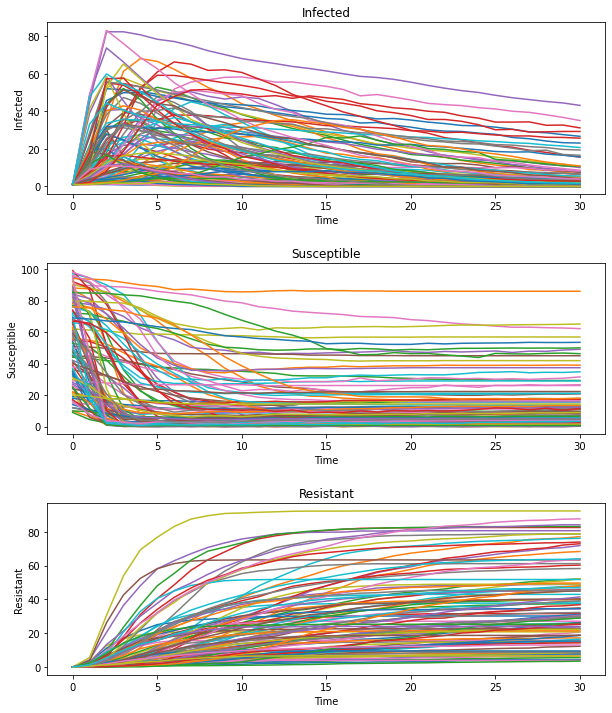

In [16]:
# plotting all of the results
plt.rcParams['figure.figsize'] = [10, 12]

figure = lines(experiments, outcomes_2D) #show lines, and end state density
plt.show()

### Sensitivity analysis

In [17]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

sa_results = perform_experiments(model, scenarios=100, uncertainty_sampling='sobol')

sa_experiments, sa_outcomes = sa_results

[MainProcess/INFO] performing 1400 scenarios * 1 policies * 1 model(s) = 1400 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 980 cases completed
[MainProcess/INFO] 1120 cases completed
[MainProcess/INFO] 1260 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] experiments finished


##### Sample size for Sobol
To calculate first-order, second-order and total sensitivity indices, 
this gives a sample size of n(2p+2), where p is the number of input parameters, 
and n is a baseline sample size which should be large enough to stabilize the estimation of the indices.
from https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html#Using-SALib-for-sensitivity-analysis

In [18]:
sa_outcomes_2D = {key:np.mean(sa_outcomes[key],axis=1) for key in sa_outcomes.keys()}
sa_results_2D = (sa_experiments.copy(), sa_outcomes_2D)

In [19]:
normalized_resistant = (sa_outcomes_2D['Resistant'][:,-1] / sa_experiments['num_nodes']).to_numpy()
normalized_resistant

array([0.55263158, 0.35438596, 0.73684211, ..., 0.41710526, 0.51710526,
       0.54078947])

In [20]:
sa_problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(sa_problem, normalized_resistant,
                   calc_second_order=True, print_to_console=False)

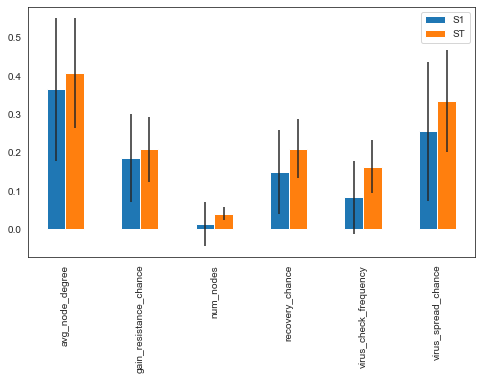

In [21]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=sa_problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [22]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=sa_problem['names'])

In [23]:
Si_df

,ST,ST_conf,S1,S1_conf
avg_node_degree,0.407109,0.142684,0.363802,0.185870
gain_resistance_chance,0.207249,0.084930,0.185916,0.114603
num_nodes,0.039211,0.016965,0.013169,0.056992
recovery_chance,0.209407,0.077866,0.148606,0.108317
virus_check_frequency,0.162277,0.069145,0.082053,0.094629
virus_spread_chance,0.333937,0.132229,0.254791,0.181426


In [24]:
#modified from https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html#Using-SALib-for-sensitivity-analysis
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=sa_problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=sa_problem['names'],
                      columns=sa_problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = sa_problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(locs) #steipatr, changed from ticklocs

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2 #steipatr, added to bugfix
        
        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

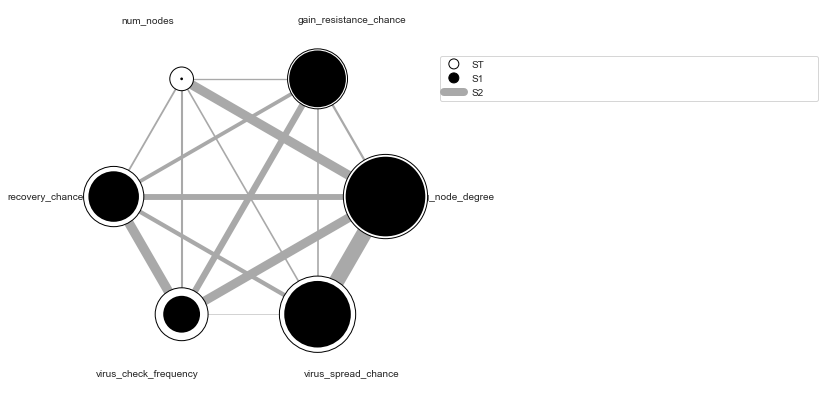

In [25]:
sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()